In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import integrate
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
def get_interaction_matrix(r1, r2, a12, a21, k1, k2):
    return np.array([[r1/k1, r1*a12/k1],
                     [r2*a21/k2, r2/k2]])


def dx_dt(x, t=0, r=None, a=None, k=None):
    """
    Return the growth rate of fox and rabbit populations.
    # competitive LV model, not predator-prey model
    # https://en.wikipedia.org/wiki/Competitive_Lotka%E2%80%93Volterra_equations
    """
    x[x < 1e-9] = 0
    k = k.reshape(-1, 1)
    x = x.reshape(-1, 1)
    r = r.reshape(-1, 1)
    # print(f'>>> {t}: {np.ravel(x * (r + int_max @ x))}')
    # print(x.shape, a.shape, k.shape)
    a[a < 1e-9] = 0
    return np.ravel(x * r * (1 - a @ x * 1/k))


def forward_predict(dx_dt, x_0, t, r, a, k):
    x_pred, infodict = integrate.odeint(dx_dt, x_0, t, args=(r, a, k), full_output=True)
    print(infodict['message'])
    return x_pred


def obj_func(ra, t, k, x_true, dx_dt):
    r, a = to_matrix(ra)
    a[a < 1e-9] = 0
    x_0 = x_true[0, :]
    x_pred = integrate.odeint(dx_dt, x_0, t, args=(r, a, k))
    return mean_squared_error(y_true=x_true, y_pred=x_pred)


def dX_dt2(x, t=0, r=None):
    # int_max = np.array([[10, 7, 12],
    #                     [15, 10, 8],
    #                     [7, 11, 10]])
    int_max = np.array([[10, 7],
                        [15, 10]])
    return np.ravel(x * (r - int_max @ x))


def generate_data(n_species=3, k=None, t=None, result_file_path=None, a=None, r=None, x_0=None):
    n = n_species
    # r = np.array([1, 1])  # r1, r2
    
    # t = np.linspace(0, 100, m)  # time
    if x_0 is None:
        x_0 = np.random.random(n)  # initialize conditions: n species
    # print(x_0)
    
    x = forward_predict(dx_dt=dx_dt, a=a, r=r, x_0=x_0, k=k, t=t)
    # print(len(x), x)
    if result_file_path is not None:
        x_df = pd.DataFrame(data=x, index=t, columns=[f'species{i}' for i in range(n_species)])
        x_df.to_csv(result_file_path, float_format='%g')
    return x


def to_vector(r, a, n_species=3):
    assert r.shape == (n_species, 1)
    assert a.shape == (n_species, n_species)
    return np.hstack([r.flatten(), a.flatten()])


def to_matrix(vec, n_species=3):
    """

    :param vec: r (3 by 1) + a (3 by 3)
    :param n_species:
    :return:
    """
    assert vec.shape == (n_species + n_species ** 2,)
    return vec[:n_species].reshape(n_species, 1), vec[n_species:].reshape(n_species, n_species)


def plot_density_over_time(t, x, result_file_path=None, title=None):
    """

    :param t: m time points
    :param x: m by n_species
    :param result_file_path:
    :return:
    """
    plt.figure(figsize=(8, 6))
    for i, species in enumerate(x.T):
        # species1, species2, species3 = X.T
        plt.plot(t, species, label=f'species{i+1}')
        # p.plot(t, species2, 'b-', label='species2')
        # p.plot(t, species3, 'y-', label='species3')
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('population')
    if title is not None:
        plt.title(title)
    if result_file_path is not None:
        plt.savefig(result_file_path, dpi=200)

In [3]:
def plot_density_over_longer_time(t, x=None, result_file_path=None, title=None, m=1000):
    """

    :param t: m time points
    :param x: m by n_species for both x_true and x_pred, a dict
    :param result_file_path:
    :return:
    """
    plt.figure(figsize=(15, 12))
    plt.axvline(x=t[m], label=f'$t_m$')
    for i, species in enumerate(x['x_true'].T):
        plt.plot(t, species, label=f'species{i+1}_true')
    for i, species in enumerate(x['x_pred'].T):
        plt.plot(t, species, label=f'species{i+1}_pred', linestyle=(0, (5, 10)))

    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('population')
    if title is not None:
        plt.title(title)
    if result_file_path is not None:
        plt.savefig(result_file_path, dpi=200)

### Example1

In [4]:
current_id = 'example1'
n_species = 3
m = 1000
t = np.linspace(0, 100, m)  # time
k = np.array([1] * n_species)  # k1, k2， carrying capacity, fix to 1 for all species
result_fp = f'raw_data_{current_id}.csv'

a = np.array([[1, 0.7, 1.2],
             [1.5, 1, 0.8],
             [0.7, 1.1, 1]])
r = np.array([2] * n_species)  # inherent growth rate

if not os.path.exists(result_fp):
    # x_true, m by n_species
    x_true = generate_data(result_file_path=result_fp, t=t, k=k, n_species=n_species, a=a, r=r)
else:
    print(f'Using generated dataset: {result_fp}')
    x_true = pd.read_csv(result_fp, index_col=0)
    x_true = x_true.values

Using generated dataset: raw_data_example1.csv


#### Plotting ground truth

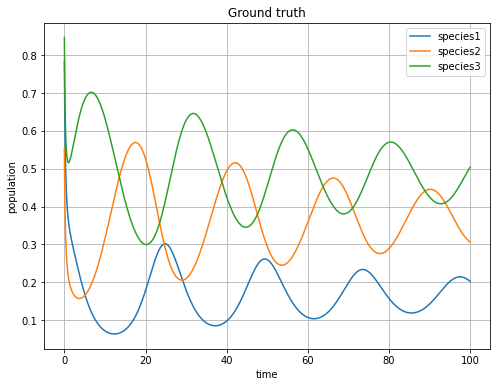

In [5]:
plot_density_over_time(t=t, x=x_true, result_file_path=f'3species_competitive_LV_model_x_true_{current_id}.png',
                       title='Ground truth')

#### Fitting $r$ and $a$

In [6]:
# estimate parameters of a and r
# x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
np.random.seed(1825)
r_init = np.random.random((n_species, 1))
a_init = np.random.random((n_species, n_species))
res = minimize(obj_func, to_vector(r=r_init, a=a_init), args=(t, k, x_true, dx_dt), tol=1e-8)
r_pred, a_pred = to_matrix(res.x)
print(to_matrix(res.x))

(array([[0.77064416],
       [2.1183687 ],
       [0.67438066]]), array([[1.32920155, 0.29000174, 1.32435753],
       [1.70527282, 0.91198675, 0.73081296],
       [0.23802537, 1.35144936, 1.02071172]]))


Integration successful.


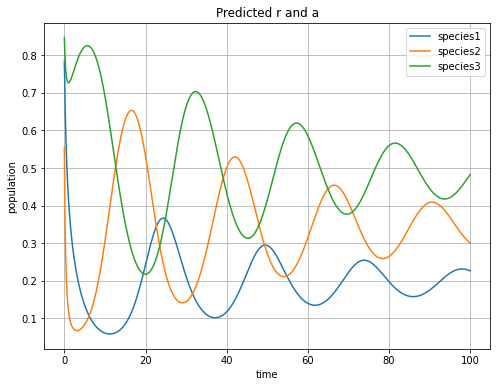

In [7]:
x_pred = forward_predict(dx_dt=dx_dt, a=a_pred, r=r_pred, x_0=x_true[0, :], k=k, t=t)
plot_density_over_time(t=t, x=x_pred, result_file_path=f'3species_competitive_LV_model_x_pred_{current_id}.png',
                       title='Predicted r and a')

#### Behaviors of longer time

In [8]:
t2 = np.linspace(0, 500, m + 4000)  # time
x_true_longer = generate_data(t=t2, k=k, n_species=n_species, a=a, r=r, x_0=x_true[0, :])
x_pred_longer = generate_data(t=t2, k=k, n_species=n_species, a=a_pred, r=r_pred, x_0=x_true[0, :])

Integration successful.
Integration successful.


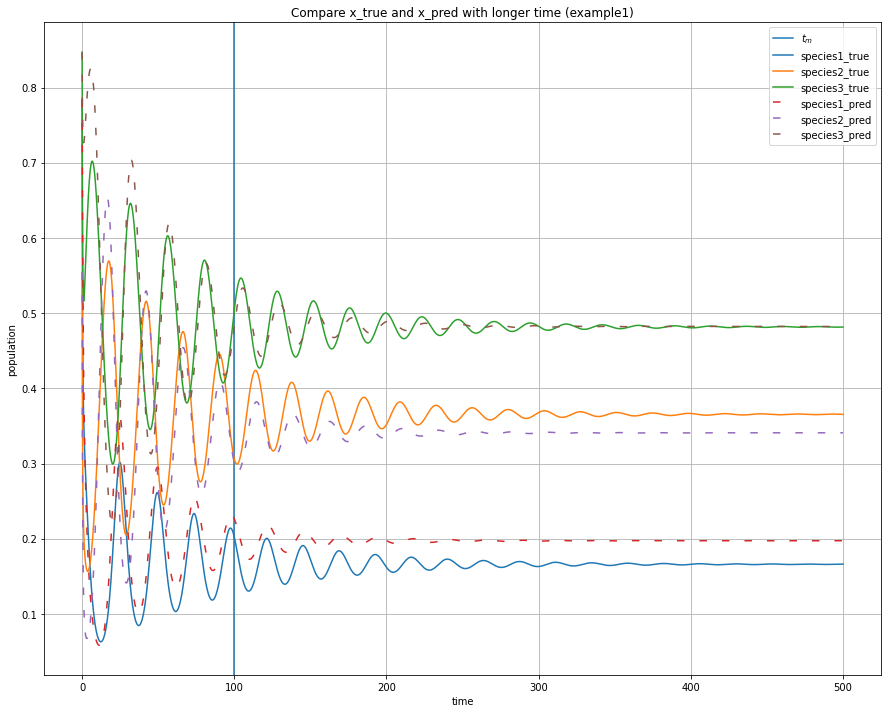

In [9]:
x_both = {'x_true': x_true_longer, 'x_pred': x_pred_longer}
plot_density_over_longer_time(t=t2, x=x_both, result_file_path=f'compare_x_true_and_x_pred_longer_time_{current_id}.png', 
                              title=f'Compare x_true and x_pred with longer time ({current_id})', m=999)

In [10]:
mean_squared_error(y_true=x_true, y_pred=x_pred)

0.0022003193133247165

In [11]:
mean_squared_error(y_true=x_true_longer[m:, :], y_pred=x_pred_longer[m:, :])

0.0005704657301246612

### Example2

In [12]:
current_id = 'example2'
n_species = 3
m = 1000
t = np.linspace(0, 100, m)  # time
k = np.array([1] * n_species)  # k1, k2， carrying capacity, fix to 1 for all species
result_fp = f'raw_data_{current_id}.csv'

a = np.array([[1, 0.7, 1.2],
             [1.5, 1, 0.8],
             [0.7, 1.1, 1]])
r = np.array([10] * n_species)  # inherent growth rate

if not os.path.exists(result_fp):
    # x_true, m by n_species
    x_true = generate_data(result_file_path=result_fp, t=t, k=k, n_species=n_species, a=a, r=r)
else:
    print(f'Using generated dataset: {result_fp}')
    x_true = pd.read_csv(result_fp, index_col=0)
    x_true = x_true.values

Using generated dataset: raw_data_example2.csv


#### Plotting ground truth

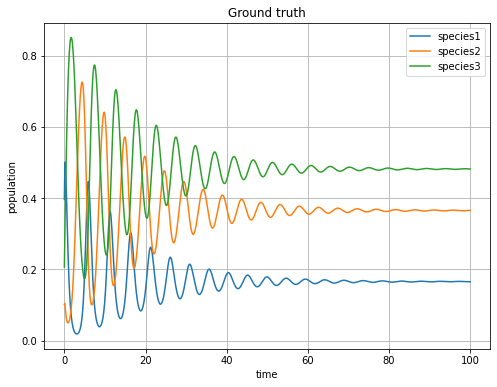

In [13]:
plot_density_over_time(t=t, x=x_true, result_file_path=f'3species_competitive_LV_model_x_true_{current_id}.png',
                       title='Ground truth')

#### Fitting $r$ and $a$

In [14]:
# estimate parameters of a and r
# x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
np.random.seed(1842)
r_init = np.random.random((n_species, 1))
a_init = np.random.random((n_species, n_species))
res = minimize(obj_func, to_vector(r=r_init, a=a_init), args=(t, k, x_true, dx_dt), tol=1e-8)
r_pred, a_pred = to_matrix(res.x)
a_pred[a_pred < 0] = 0
print(to_matrix(res.x))

(array([[1.93432152],
       [1.33602931],
       [4.14009202]]), array([[2.07993056, 0.        , 1.27700487],
       [2.19818882, 1.52375972, 0.        ],
       [0.        , 1.97606546, 0.54757611]]))


Integration successful.


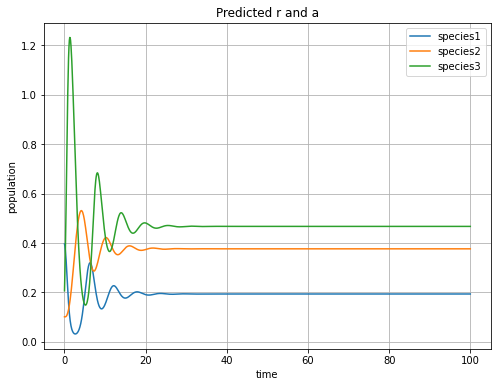

In [15]:
x_pred = forward_predict(dx_dt=dx_dt, a=a_pred, r=r_pred, x_0=x_true[0, :], k=k, t=t)
plot_density_over_time(t=t, x=x_pred, result_file_path=f'3species_competitive_LV_model_x_pred_{current_id}.png',
                       title='Predicted r and a')

#### Behaviors of longer time

In [16]:
t2 = np.linspace(0, 500, m + 4000)  # time
x_true_longer = generate_data(t=t2, k=k, n_species=n_species, a=a, r=r, x_0=x_true[0, :])
x_pred_longer = generate_data(t=t2, k=k, n_species=n_species, a=a_pred, r=r_pred, x_0=x_true[0, :])

Integration successful.
Integration successful.


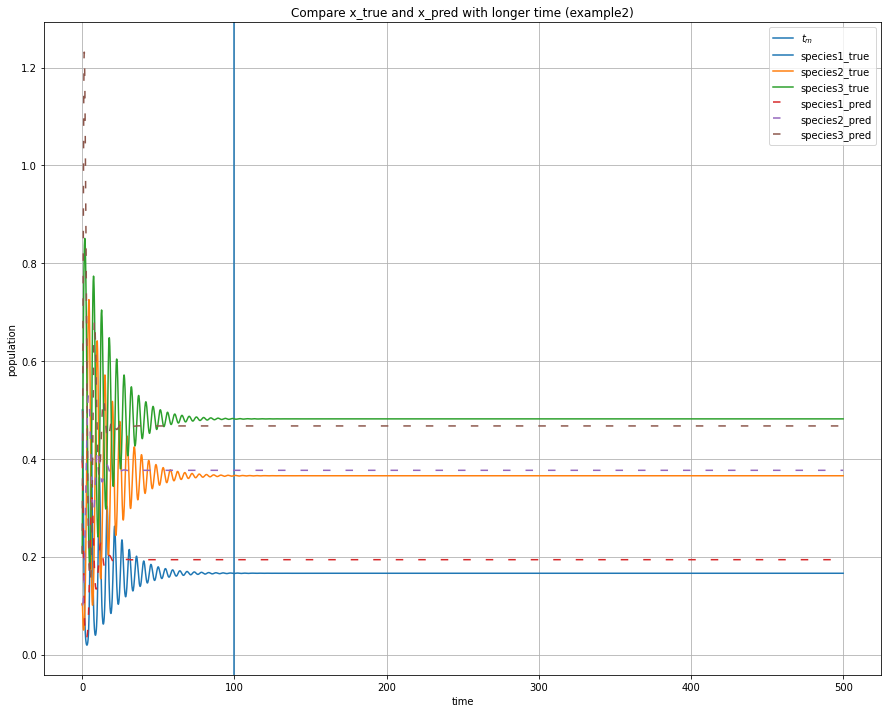

In [17]:
x_both = {'x_true': x_true_longer, 'x_pred': x_pred_longer}
plot_density_over_longer_time(t=t2, x=x_both, result_file_path=f'compare_x_true_and_x_pred_longer_time_{current_id}.png', 
                              title=f'Compare x_true and x_pred with longer time ({current_id})', m=999)

In [18]:
mean_squared_error(y_true=x_true, y_pred=x_pred)

0.004461324419934577

In [19]:
mean_squared_error(y_true=x_true_longer[m:, :], y_pred=x_pred_longer[m:, :])

0.0003678287697513416

In [20]:
current_id = 'example2'
n_species = 3
m = 1000
t = np.linspace(0, 100, m)  # time
k = np.array([1] * n_species)  # k1, k2， carrying capacity, fix to 1 for all species
result_fp = 'raw_data_example2.csv'

a = np.array([[1, 0.7, 1.2],
             [1.5, 1, 0.8],
             [0.7, 1.1, 1]])
r = np.array([10] * n_species)  # inherent growth rate

if not os.path.exists(result_fp):
    # x_true, m by n_species
    x_true = generate_data(result_file_path=result_fp, t=t, k=k, n_species=n_species, a=a, r=r)
else:
    print(f'Using generated dataset: {result_fp}')
    x_true = pd.read_csv(result_fp, index_col=0)
    x_true = x_true.values

Using generated dataset: raw_data_example2.csv


#### Plotting ground truth

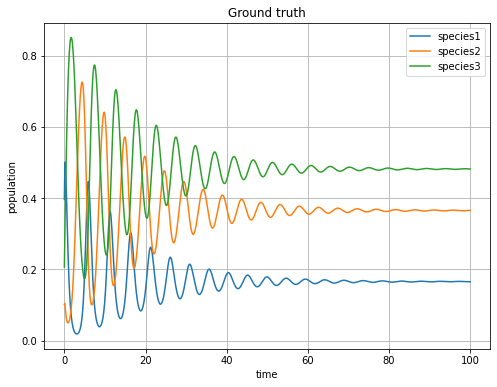

In [21]:
plot_density_over_time(t=t, x=x_true, result_file_path='3species_competitive_LV_model_x_true.png',
                       title='Ground truth')

#### Fitting $r$ and $a$

In [22]:
# estimate parameters of a and r
# x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
np.random.seed(1825)
r_init = np.random.random((n_species, 1))
a_init = np.random.random((n_species, n_species))
res = minimize(obj_func, to_vector(r=r_init, a=a_init), args=(t, k, x_true, dx_dt), tol=1e-8)
r_pred, a_pred = to_matrix(res.x)
print(to_matrix(res.x))

/Users/belter/miniconda3/envs/deside/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/belter/miniconda3/envs/deside/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/belter/miniconda3/envs/deside/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/belter/miniconda3/envs/deside/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_outp

(array([[7.15527645],
       [1.0641565 ],
       [4.03847838]]), array([[ 1.41060766, -8.17381067,  1.58406064],
       [-4.51293461,  2.71118867, -0.16770123],
       [-4.29129113,  1.30512155,  1.07881625]]))


Integration successful.


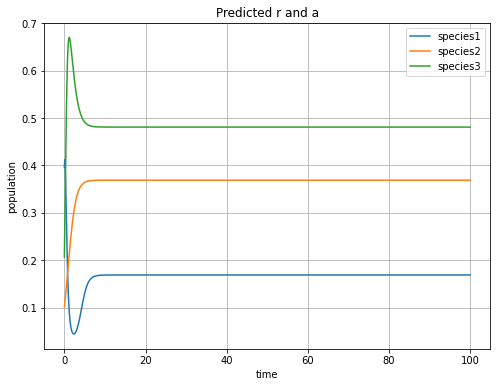

In [23]:
x_pred = forward_predict(dx_dt=dx_dt, a=a_pred, r=r_pred, x_0=x_true[0, :], k=k, t=t)
plot_density_over_time(t=t, x=x_pred, result_file_path='3species_competitive_LV_model_x_pred.png',
                       title='Predicted r and a')

#### Behaviors of longer time

In [24]:
t2 = np.linspace(0, 500, m + 4000)  # time
x_true_longer = generate_data(t=t2, k=k, n_species=n_species, a=a, r=r, x_0=x_true[0, :])
x_pred_longer = generate_data(t=t2, k=k, n_species=n_species, a=a_pred, r=r_pred, x_0=x_true[0, :])

Integration successful.
Integration successful.


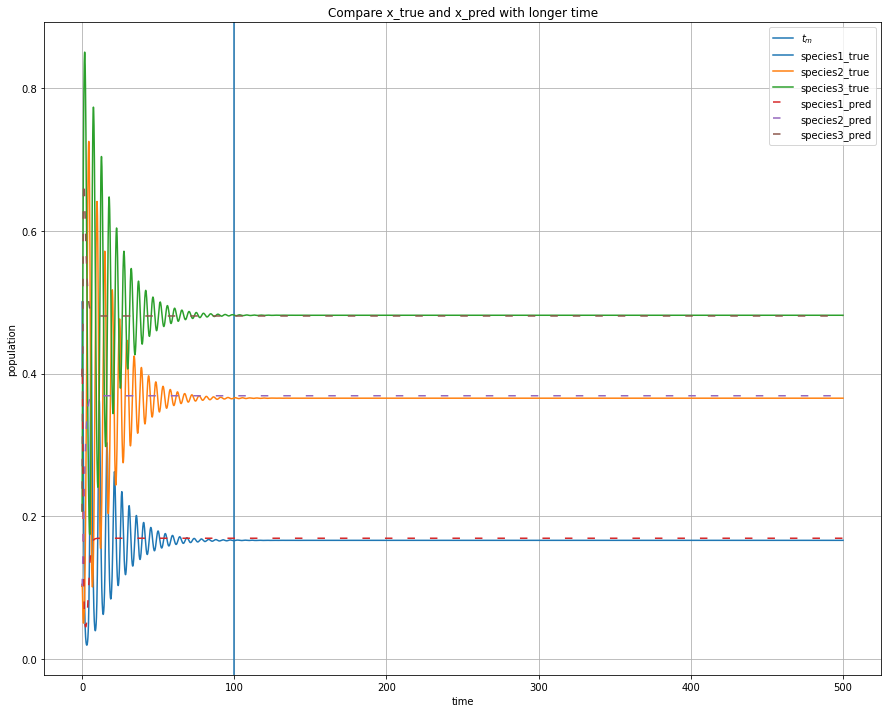

In [25]:
x_both = {'x_true': x_true_longer, 'x_pred': x_pred_longer}
plot_density_over_longer_time(t=t2, x=x_both, result_file_path='compare_x_true_and_x_pred_longer_time.png', 
                              title='Compare x_true and x_pred with longer time', m=999)

In [26]:
mean_squared_error(y_true=x_true, y_pred=x_pred)

0.005287946463444327

In [27]:
mean_squared_error(y_true=x_true_longer[m:, :], y_pred=x_pred_longer[m:, :])

7.09704779647936e-06